# Introduction
This notebook contains the work for [Homework 3](https://github.com/lucamaiano/ADM/tree/master/2022/Homework_3) 
of [Algorithmic Methods for Data Mining 2022](http://aris.me/index.php/data-mining-ds-2022).

## Group Members
* Laura Mignella
* Paolo Barba
* Jonas Barth

## Index
* [1. Data Collection](#1.-Data-Collection)
    * [1.1. Get the list of places](#1.1.-Get-the-list-of-places)
    * [1.2. Crawl Places](#1.2.-Crawl-places)
    * [1.3. Parse Pages](#1.3.-Parse-Pages)
* [2. Search Engine](#2.-Search-Engine)
    * [2.1. Conjunctive Index](#2.1.-Conjunctive-Index)
        * [2.1.1. Create Index](#2.1.1.-Create-Index)
        * [2.1.2. Create Search Engine and Run Search](#2.1.2.-Create-Search-Engine-and-Run-Search)
    * [2.2. TF-IDF Index](#2.2.-TF-IDF-Index)
        * [2.2.1. Create TF-IDF Index](#2.2.1.-Create-TF-IDF-Index)
        * [2.2.2. Create TF-IDF Search Engine and Run Search](#2.2.2.-Create-TF-IDF-Search-Engine-and-Run-Search)
* [3. Own Score](#3.-Own-Score)
    * [3.1. Proximity](#3.1.-Proximity)
    * [3.2. Popularity](#3.2.-Popularity)
    * [3.3. Proximity & Popularity](#3.3.-Proximity-&-Popularity)
* [4. Visualizing the most relevant places](#4.-Visualizing-the-most-relevant-places)
* [7. Theoretical Question](#7.-Theoretical-Question)
    * [7.1. Bubble Sort](#7.1.-Bubble-Sort)
        * [7.1.1. Time Complexity](#7.1.1.-Time-Complexity)
    * [7.2. Merge Sort](#7.2.-Merge-Sort)
        * [7.2.1. Time Complexity](#7.2.1.-Time-Complexity)
    * [7.3. Quick Sort](#7.3.-Quick-Sort)
        * [7.3.1. Time Complexity](#7.3.1.-Time-Complexity)
    * [7.4. MapReduce Sort](#7.4.-MapReduce-Sort)
    * [7.5. Sort Students](#7.5.-Sort-Students)
    * [7.6. Save Students](#7.6.-Save-Students)
    * [7.7. Evaluate Algorithms](#7.7.-Evaluate-Algorithms)
        * [7.7.1. Time Complexity](#7.7.1.-Time-Complexity)
        * [7.7.2. Space Complexity](#7.7.2.-Space-Complexity)
        * [7.7.3. Conclusion](#7.7.3.-Conclusion)

# Imports

In [1]:
import pandas as pd
from parse import parse_htmls
from util import read_place_desc, read_htmls_in, write_places_to_tsv, read_places, plot_map
from service import PlaceService, SearchEngine
from index import preprocess, Index, TfIdfIndex

import requests
from tqdm import tqdm
import os
import time
import util
import plotly.express as px

# 1. Data Collection
##  1.1. Get the list of places





In [ ]:
with open('./resources/most_popular_places.txt', 'w') as file:
    for i in tqdm(range(400)):
        
        url = 'https://www.atlasobscura.com/places?page='+str(i+1)+'&sort=likes_count'
        list_page = requests.get(url)
        list_soup = BeautifulSoup(list_page.text)
        list_places = [x['href'] for x in list_soup.find_all('a', {'class':"content-card content-card-place"})]
        for place in tqdm(list_places):
            file.write('https://www.atlasobscura.com' + str(place))
            file.write('\n')

## 1.2. Crawl places

In [ ]:
f= open('./resources/most_popular_places.txt', 'r')
for j, url in enumerate(f):
    
    if j %18 == 0:
        dir_path = f'page{j//18+1}'
        if not os.path.isdir(dir_path):
            os.mkdir(dir_path)
            
    response = requests.get(url.strip())
    with open(f'{dir_path}/{j+1}.html','w') as file:
        print()
        file.write(response.text)
        
    time.sleep(1)

# 1.3. Parse Pages

In [ ]:
all_htmls = read_htmls_in('./pages')

In [ ]:
all_places = parse_htmls(htmls)

In [ ]:
tsv_path = write_places_to_tsv('./', all_places)

The [PlaceService](service/place.py) is a class that allows the user to fetch places that were loaded by the service. We use this to have a common interface for fetching place information based on their ID.

In [37]:
place_service = PlaceService()
place_service.load('./resources/places.tsv')

---

# 2. Search Engine
The search engine is represented by the [SearchEngine](service/engine.py) class which operates on an [index](index) and a [place service](service/place.py). The search engine is responsible for accepting search queries and running them on the index it points to.

## 2.1. Conjunctive Index
The conjunctive index is an index that allows for conjunctive queries, i.e. where the returned documents contain **ALL** the words in the query.

## 2.1.1. Create Index
The index can either be created from the parsed and saved files or from an already saved index.

### Create from saved `.tsv` file.
We create the inverted index from previously saved **place IDs** and the **place descriptions**. The inverted index is a python dictionary where each entry is a **word** mapped to a list of **document IDs** of documents where the word appears in.

```python
index[word] = [place_id_1, ...]
```

The algorithm for creating the index is as follows. For each place ID and description string:

1. Preprocess the description string
    1. tokenise the description
    1. lower case tokens
    1. remove stop words
    1. stem words
    1. remove duplicate words
1. For each word in the preprocessed description, add the ID to the list of IDs that the word maps to in the dictionary.

In [38]:
ids, descriptions = read_place_desc('./resources/places.tsv')
index = Index.create_from(ids, descriptions)

### Load saved index

In [39]:
index = Index.load_from('./resources/index.pickle')

### 2.1.2. Create Search Engine and Run Search
Here, we create the `SearchEngine` with the previously created `conjunctive index` and `place service`. 

In [40]:
search_engine = SearchEngine(index, place_service)

Querying the **conjunctive index** with `american muesum` returns **244** documents. The query works as follows:

1. Preprocess the query in the same way as when creating the index.
1. Find the list of place IDs for each word.
1. Get the intersection of all lists.
1. Use the `place service` to find the places with the found place IDs.

In [41]:
search_engine.query('american museum')

,name,desc,url
1804,Uncommon Objects,Like an elegant antiques mall gone horribly wr...,https://www.atlasobscura.com/places/uncommon-o...
2458,Tamástslikt Cultural Institute,"The Tamástslikt Cultural Institute, situated o...",https://www.atlasobscura.com/places/tamastslik...
349,Mitsitam Native Foods Cafe,"A visit to the National Mall in Washington, D....",https://www.atlasobscura.com/places/mitsitam-n...
3701,Museum of Chinese in America,The Museum of Chinese in America is nestled—al...,https://www.atlasobscura.com/places/museum-of-...
1087,Museum of Mourning Art,Mourning and personal response to death are un...,https://www.atlasobscura.com/places/museum-of-...
...,...,...,...
6473,Museum of the American Cocktail,They say that New Orleans is the home of the f...,https://www.atlasobscura.com/places/museum-ame...
1934,Unto These Hills Cherokee Theatre,"Since 1950, members of the local Cherokee trib...",https://www.atlasobscura.com/places/unto-these...
984,Theodore Roosevelt Birthplace Museum,Behind an otherwise innocuous (if immaculately...,https://www.atlasobscura.com/places/theodore-r...
620,Canyons of the Ancients,Ripe for quiet reflection and simply awe-inspi...,https://www.atlasobscura.com/places/canyons-of...


## 2.2. TF-IDF Index
The TF-IDF index is an index that saves a TF-IDF score alongside each place ID. 

```python
index[word] = [(tf_idf, place_id), ...]
```

The TF-IDF is a product that consists out of:

1. Term Frequency. $TF (n_w) = \frac{n_w}{|D|}$ where $n_w$ is the number times the word $w$ appears in the description $D$ and $|D|$ is the number of words in the description $D$.
1. Inverse Document Frequency. $IDF (w) = log \frac{N}{|w \in D|}$ where where $N$ is the total number of descriptions and $|w \in D|$ is the number of documents that the word $w$ appears in.

The final number is a score that tells us how important a word is in a description and the entire corpus of descriptions.

### 2.2.1. Create TF-IDF Index
The index can either be created from the parsed and saved files or from an already saved index.

### Ceate from saved `.tsv` file
Similarly to the [conjunctive index](#2.1.-Conjunctive-Index) when creating the [TF-IDF index](index/tf_idf_index.py), we create the index from a list of **place IDs** and **place descriptions**.

The algorithm to create the TF-IDF index is as follows:

1. **preprocess** the descriptions as we did for the [conjunctive index](#2.1.-Conjunctive-Index)
1. For each word calculate the $TF$ score and save it in the index. We use a [dedicated class](index/tf_idf_index.py) with overridden operators to store the tuple of the `score` and `place ID` so that we can easily compare the tuples without having to unpack everytime. 
1. For each word calculate the $IDF$ and multiply it with the previously stored $TF$ score to create the `TF-IDF` score.

In [42]:
tf_idf_index = TfIdfIndex.create_from(ids, descriptions)

### Load saved index

In [43]:
tf_idf_index = TfIdfIndex.load_from('./resources/tf_idf_index.pickle')

### 2.2.2. Create TF-IDF Search Engine and Run Search
This time we create the `SearchEngine` with the previously created `tf_idf_index` and run a query for the **top 10** places that match `american museum`.

The query is a bit more complex than the conjunctive query we did before. The general idea is that we fetch the list of `(TF-IDF, place ID)` tuples for each word in the query, create one pointer per list, walk through the lists simultaneously, and save the `cosine similarity` of the query TF-IDF and the TF-IDF of the place **IF** all pointers are pointing to the same place tuple. 

1. preprocess the query
1. calculated `TF-IDF` score for query.
1. create a priority queue to hold the **top 10** place IDs and their scores.
1. for each word in the query, get all (TF-IDF, place ID) tuples.
1. create one pointer per list of tuples.
1. if all pointers point to the same place:
    1. calculate `cosine similarity` between the `query TF-IDF` and the `place TF-IDF`.
    1. if the priority queue is full:
        1. pop the priority queue
        1. add the $max$ of the popped score and the newly calculated `cosine similarity` back into the queue.
    1. add the newly calculated `cosine similarity` into the queue.
1. increase the lowest pointer by 1.
1. stop if the lowest pointer has reached the last item in its list.
1. return the items from the priority queue

We see that the **top 10** scores are very close to $1$, meaning that their TF-IDF scores are very similar to the ones of the query.

In [44]:
tf_idf_search_engine = SearchEngine(tf_idf_index, place_service)
tf_idf_search_engine.query_top_k("american museum", 10)[['name', 'desc', 'url', 'similarity']]

,name,desc,url,similarity
3926,Smithsonian Sushi Collection,The American History Museum has collected an a...,https://www.atlasobscura.com/places/smithsonia...,0.999944
6489,Mercer Museum and Fonthill Castle,"Henry Chapman Mercer, a renowned archaeologist...",https://www.atlasobscura.com/places/fonthill,0.998837
2458,Tamástslikt Cultural Institute,"The Tamástslikt Cultural Institute, situated o...",https://www.atlasobscura.com/places/tamastslik...,0.998837
4697,Zippo/Case Museum,Invented in and still proudly manufactured in ...,https://www.atlasobscura.com/places/zippo-case...,0.998837
238,Off the Rez Cafe,The U.S. government’s forced relocation of Nat...,https://www.atlasobscura.com/places/off-the-re...,0.998837
6238,Oak Ridge &quot;The Secret City&quot;,The city of Oak Ridge was established by the U...,https://www.atlasobscura.com/places/the-secret...,0.998837
5429,Old Time Wooden Nickel Company,"The adage goes, “don’t take any wooden nickels...",https://www.atlasobscura.com/places/old-time-w...,0.994973
5068,Self-Taught Genius Gallery,"In 2017, the American Folk Art Museum in Manha...",https://www.atlasobscura.com/places/self-taugh...,0.992310
5517,Niles Essanay Silent Film Museum,It was Spring in San Francisco. One quiet Apri...,https://www.atlasobscura.com/places/niles-essa...,0.988467
343,Gillette Castle State Park,"High above the Connecticut River, Gillette Cas...",https://www.atlasobscura.com/places/gillettes-...,0.988467


---

# 3. Own Score
For our own score, we decided to give the users three ways to rank the places:

1. [Proximity](#3.1.-Proximity)
1. [Popularity](#3.2.-Popularity)
1. [Proximity & Popularity](#3.3.-Proximity-&-Popularity)

## 3.1. Proximity
We chose to give the user an option for ranking places according to proximity to the user's location because wanting to know what places are close to your location might be relevant when you are exploring a new city as a tourist for example.

The proximity score is based on the user's current location. Places that are closer to the user's location are ranked higher than places that are further away. To user's location is obtained by fetching the currently used IP address and finding the latitudes and longitudes associated with it. Although not exact and prone to manipulation (a VPN could be used to "change" location), we avoid having to clean and parse more user input.

The similarity score for a place is calculated by subtracting the distance between the user location from the maximum possible distance, and normalising it over the maximum possible distance. Given a distance function $dist(p_1, p_2)$ that returns the distance between two positions on the surface of the earth, the proximity score is defined as:

$$proximity(place) = \frac{max\_distance - dist(place, user)}{max\_distance}$$

The $max\_distance$ is simply the earth's circumference divided by two, as this is the maximum possible distance between any two points on the surface of the earth.

The reason for subtracting the distance between the user and the place from the maximum distance is so that scores closer to 1 correspond to a higher similarity and scores closer to 0 to lower similarity. More formally:

$$\lim_{dist(place, user) \to 0} proximity(place) = 1$$

$$\lim_{dist(place, user) \to max\_distance} proximity(place) = 0$$

In [45]:
search_engine.query_custom('museum', top_k=10, proximity=True, popularity=False)[["name","desc","address","similarity"]]

,name,desc,address,similarity
4392,Museo Atlántico,"Completely submerged under the Atlantic Ocean,...","C. Las Palmas, 131, Costa de Playa Blanca, Pla...",0.824581
3446,Jardin Majorelle,"The Jardin Majorelle, or Majorelle Garden, is ...","Rue Yves St Laurent, Marrakesh, Morocco",0.820223
3324,Metropol Parasol,When Jürgen Mayer-Hermann designed and began c...,"La Encarnacion Square, Seville, 41003, Spain",0.791101
5179,White Desert,Just a few hours from the bursting metropolis ...,"Al Farafrah, Egypt",0.788727
3619,Mina de São Domingos (Sao Domingos Mines),"With its derelict abandoned buildings, blood-r...","N265, 7750, Portugal",0.788321
3514,Bourke&#39;s Luck Potholes,At the confluence of the Blyde River and the T...,"Unnamed Road, Ehlanzeni, South Africa",0.785515
3729,Electricity Museum,Whether it is art or industrial history that S...,"Av. Brasília, Lisbon, 1300-598, Portugal",0.781075
5438,National Coach Museum,"Created by Queen Amélia of Portugal in 1905, t...","136 Av. da Índia, Lisbon, 1300-300, Portugal",0.781069
6130,Carmo Convent Ruins,"“Come, ye philosophers, who cry, ‘All’s well,’...","Carmo Archaeological Museum, Largo do Carmo 92...",0.781049
1560,Bordallo Pinheiro Garden,A beautiful small garden in the Museum of the ...,"Campo Grande 245, Lisbon, 1700-091, Portugal",0.780783


## 3.2. Popularity
Popularity also plays a role in relevance. Popular places are often must-sees, so it is important for the user to know which these places are.

The popularity score ranks places by popularity, with more popular places being above less popular places. The popularity of a place is calculated using the number of people that have visited it and the number of people that want to go. We chose these two variables, because the very meaning of popularity is that many people are interested in a place. If many people want to go to a place or have visited it, it therefore means that is popular.

For the number of people that went and number of people that want to go, we calculate their ratio over the total number of people that visited all places and the total number, sum them, and equally weigh the two ratios. 

$$popularity = \frac{1}{2} \times \left(\frac{num\_people\_went}{total\_people\_went} + \frac{num\_people\_want}{total\_people\_want}\right)$$



In [46]:
search_engine.query_custom("museum", top_k=10, proximity=False, popularity=True)[["name","desc","address","similarity"]]

,name,desc,address,similarity
2000,Mütter Museum,Located inside the headquarters of the College...,"19 South 22nd Street, Philadelphia, Pennsylvan...",0.005018
6820,Museum of Pop Culture,"In Seattle, where art seems to spring from the...","325 5th Avenue North, Seattle, Washington, 981...",0.004714
0,City Hall Station,The first New York City subway was built and o...,"31 Centre St, New York, New York, 10007, Unite...",0.004609
614,Natural History Museum of London,"Established in 1881, the Natural History Museu...","Cromwell Road, London, England, SW7 2DD, Unite...",0.004500
14,The Evolution Store,Evolution stands out among the clothing stores...,"687 Broadway, New York, New York, 10012, Unite...",0.004283
5999,The Witch House of Salem,The Salem witchcraft trials took place between...,"310 1/2 Essex Street, Salem, Massachusetts, 01...",0.003955
825,Casa Batlló,"One of Gaudí’s most iconic works, Casa Batlló ...","43 Passeig de Gràcia, Barcelona, 08007, Spain",0.003873
5011,Park Güell,"At Park Güell, stone, tile, plants, and Medite...","s/n Carrer d'Olot, Barcelona, 08024, Spain",0.003774
4411,Centre Pompidou,"Located in Paris’ 4th arrondissement, Centre G...","Centre Georges Pompidou, Paris, 75004, France",0.003709
1010,La Brea Tar Pits Dragonfly Fossils,The landmarked La Brea Tar Pits and Museum is ...,"La Brea Tar Pits and Museum, 5801 Wilshire Bou...",0.003677


## 3.3. Proximity & Popularity
For the combination of proximity and popularity, the two scores are simply multiplied together.

$$proximity \times popularity$$

In [47]:
search_engine.query_custom("museum" , top_k=10, proximity=True, popularity=True)[["name","desc","address","similarity"]]

,name,desc,address,similarity
614,Natural History Museum of London,"Established in 1881, the Natural History Museu...","Cromwell Road, London, England, SW7 2DD, Unite...",0.003218
825,Casa Batlló,"One of Gaudí’s most iconic works, Casa Batlló ...","43 Passeig de Gràcia, Barcelona, 08007, Spain",0.002986
5011,Park Güell,"At Park Güell, stone, tile, plants, and Medite...","s/n Carrer d'Olot, Barcelona, 08024, Spain",0.002909
2000,Mütter Museum,Located inside the headquarters of the College...,"19 South 22nd Street, Philadelphia, Pennsylvan...",0.002827
4411,Centre Pompidou,"Located in Paris’ 4th arrondissement, Centre G...","Centre Georges Pompidou, Paris, 75004, France",0.002706
0,City Hall Station,The first New York City subway was built and o...,"31 Centre St, New York, New York, 10007, Unite...",0.002615
14,The Evolution Store,Evolution stands out among the clothing stores...,"687 Broadway, New York, New York, 10012, Unite...",0.002431
5999,The Witch House of Salem,The Salem witchcraft trials took place between...,"310 1/2 Essex Street, Salem, Massachusetts, 01...",0.002286
7008,221b Baker Street,Beeton’s Christmas Annual was a hugely popular...,"237 Baker Street, Devon, London, England, NW1 ...",0.002025
426,International Spy Museum,Lipstick pistols and the Enigma cipher machine...,"700 L'Enfant Plaza SW, Washington, District of...",0.001990


## 3.4. Score Evaluation
Comparing the cosine similarity with our own function is not clear cut, as they operate according to different metrics and cater to different needs. Therefore it is not trivial to say which one is better or worse.

The cosine similarity is good for checking document similarity based on the actual content, whereas the other scores take into account other variables that the user might be interested in.

---

# 4. Visualizing the most relevant places

In [48]:
d_cosine = tf_idf_search_engine.query_top_k("american museum", 10)
d_proximity = search_engine.query_custom('american museum', top_k=10, proximity=True, popularity=False)
d_popularity = search_engine.query_custom("american museum", top_k=10, proximity=False, popularity=True)
d_combination = search_engine.query_custom("american museum" , top_k=10, proximity=True, popularity=True)

In [49]:
plot_map(d_cosine, "Maps visualization of the most relevant place according to cosine similarity")

In [50]:
plot_map(d_popularity, "Maps visualization of the most relevant place according to popularity")

In [51]:
plot_map(d_proximity, "Maps visualization of the most relevant place according to proximity")

In [52]:
plot_map(d_combination, "Maps visualization of the most relevant place according to proximity and popularity")

---

# 7. Theoretical Question

In [65]:
from parse import parse_students_from
from util import write_students

In [66]:
students = parse_students_from('ApplicantsInfo.txt')

## 7.1. Bubble Sort

In [67]:
def bubble_sort(arr):
    """In place implementation of ascending bubble sort O(n^2). """
    for i in range(len(arr)):
        
        for j in range(len(arr) - i - 1):
            
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]

### 7.1.1. Time Complexity

The time complexity of the Bubble sort is $\Theta(N^2)$.

Bubble sort is a simple sorting algorithm that goes through the elements of the list and compares the current element with the one after it, then if the first one is bigger it swaps the two. After the first iteration we have the bigger element of the list in the last position. 

So in general, in the $i^{th}$ iteration we go through the elements of the list and we swap as needed up until the $(N-i)^{th}$ element. After N iterations we obtain the sorted list.

```python
    for i in range(len(arr)):                               #N times (N=length of arr)
        for j in range(len(arr) - i - 1):                   #N-i-1 times, i=0,...,N
            if arr[j] > arr[j + 1]:                         #θ(1)
                arr[j], arr[j + 1] = arr[j + 1], arr[j]     #θ(1)
```

---

## 7.2. Merge Sort
Inspired by https://www.javatpoint.com/merge-sort

In [68]:
def merge(arr, left, middle, right):
    """Merges two arrays"""
    
    # Get all items belonging to the left and right arrays
    left_arr = [arr[left + i] for i in range(middle - left + 1)]
    right_arr = [arr[middle + 1 + i] for i in range(right - middle)]

    # indeces to keep track of
    main_index = left
    left_index = 0
    right_index = 0

    while len(left_arr) > left_index and len(right_arr) > right_index:

        left = left_arr[left_index]
        right = right_arr[right_index]

        if left < right:
            arr[main_index] = left
            left_index += 1

        else:
            arr[main_index] = right
            right_index += 1

        main_index += 1
    
    # add items that are leftover in the left array
    while left_index < len(left_arr):
        arr[main_index] = left_arr[left_index]
        main_index += 1
        left_index += 1

    # add items that are leftover in the right array
    while right_index < len(right_arr):
        arr[main_index] = right_arr[right_index]
        main_index += 1
        right_index += 1

In [69]:
def merge_sort(arr, left, right):
    """In place implementation of merge sort in ascending order."""
    if left < right:
        middle = (left + right) // 2
        
        # sort the left part of the array
        merge_sort(arr, left, middle)
        
        # sort the right part of the array
        merge_sort(arr, middle + 1, right)
        
        # merge the two sorted arrays
        merge(arr, left, middle, right)
    

### 7.2.1. Time Complexity
The computational time of the Merge sort is $\theta(n log(n))$.

The idea behind the merge sort is to divide the problems into subproblems, solve them and combine the solutions.

The array of size n will be divided into two arrays of size n/2, these two array will be divided further into 4 arrays of size n/4, and so on until each subarray reach a single element. Then we combine all the arrays in a way that results are sorted.

The computational cost can be splitted in two parts:

* The cost of recursevely sort an array of size 
* The cost of combine two array into one



Time complexity in the worst case:

\begin{cases}
  T(n)  = c if n = 1\\
  T(n)  = 2 T(\frac{n}{2}) + 2cn \hspace{0.5cm}   if n \geq 1 
\end{cases}

$ T(n) = 2 T(\frac{n}{2}) + 2cn $  Cost at level 1


$ 4 T(\frac{n}{4}) + 4 + 4cn   $

in general:

$$ T(\frac{n}{2^{k}}) = 2^{k} T(\frac{n}{2^{k}}) + kcn $$


it will end when $\frac{n} {2^{k}} $ is equal to 1 , $k = \log(n) $

it will get:

$$ T(n) = 2^{log(n)} T(1) + log(n) cn + c $$

since $T(1) = c$  and $ 2^{log(n)} = n$ time complexity will be : 

$$ T(n) = \Theta(n + nlog(n)) =\Theta(n log(n)) $$


The computational time of the merge sort is the same in the best, worst or random case. 

---

## 7.3. Quick Sort

In [70]:
import random 
def quick_sort(arr):

    if len(arr) == 0 or len(arr)==1:
        return arr
    else:
        idx = random.randint(0,len(arr) -1)
        arr_1=partion_1(arr, idx)
        arr_2=partion_2(arr, arr[idx])
        a_1=quick_sort(arr_1)
        a_2=quick_sort(arr_2)
    return a_1 + [arr[idx]] + a_2
       

In [71]:
def partion_1(a,pivot):
    arr=[]
    for i,l in enumerate(a):
        if l <= a[pivot] and i != pivot:
            arr.append(l)
            
    return arr

In [72]:
def partion_2(a,pivot):
    arr=[]
    for x in a:
        if x > pivot:
            arr.append(x)
            
    return arr

### 7.3.1. Time Complexity
The time complexity of the Quicksort is, on average, $\Theta(N \cdot log(N))$ while in the worst case the time complexity is $\Theta(N^2)$.

Quicksort works by selecting a random 'pivot' element from the list and partitioning the other elements into two sub-lists, the first list containing the elements smaller than the pivot, the second one containing the largest elements. The sub-lists are then sorted recursively. 

The time complexity of the base case is $\Theta(1)$.

In the worst case:

$T(N)=\Theta(N)+ T(N-1) \hspace{0.5cm}   if\ n > 1$

$T(N) = \Theta(N)+ T(N-1)= \Theta(N)+ \Theta(N-1)+ T(N-2)= \sum_\limits{k=0}^{N-1} \Theta(N) +T(1)= \Theta(N^2)$

The worst case occurs when one of the sub-lists is of size N-1. This happens when the pivot is the smallest or the largest element in the list. If this happens repeatedly in each partition the time complexity would be $\Theta(N^2)$.

In the average case:

$T(N)=\Theta(N)+ 2 \cdot T(\frac{N}{2}) \hspace{0.5cm}   if\ n > 1$

We know that as in the Merge sort, in this case, $T(N)=\Theta(N \cdot log(N))$.

In the average case, each time we perform a partition we divide the list into two sub-lists with lenght around $\frac{N}{2}$.

---

## 7.4. MapReduce Sort
The map reduce sorting algorithm we implemented is a merge sort that creates a new sorted array.

In [73]:
def mr_merge(left, right):
    """Merges two arrays into a new array."""

    sorted_arr = [0] * (len(left) + len(right))
    # indeces to keep track of
    main_index = 0
    left_index = 0
    right_index = 0

    while len(left) > left_index and len(right) > right_index:

        left_el = left[left_index]
        right_el = right[right_index]

        if left_el < right_el:
            sorted_arr[main_index] = left_el
            left_index += 1

        else:
            sorted_arr[main_index] = right_el
            right_index += 1

        main_index += 1

    # add items that are leftover in the left array
    while left_index < len(left):
        sorted_arr[main_index] = left[left_index]
        main_index += 1
        left_index += 1

    # add items that are leftover in the right array
    while right_index < len(right):
        sorted_arr[main_index] = right[right_index]
        main_index += 1
        right_index += 1

    return sorted_arr

In [74]:
def map_reduce_sort(arr):
    """Sorts the array using Spark's map and reduce functions."""
    sc = pyspark.SparkContext(appName="sort")

    spark_arr = sc.parallelize(arr)
        #distData.sortBy(keyfunc=lambda e: e).collect()
    sorted_arr = spark_arr.map(lambda element : [element]).reduce(mr_merge)
        # map needs to split the array into sub arrays of size 1
    sc.stop()
    
    return sorted_arr

## 7.5. Sort Students

In [75]:
students = quick_sort(students)[::-1]

In [76]:
merge_sort(students,0 , len(students)-1)
students = students[::-1]

In [77]:
bubble_sort(students)
students = students[::-1]

## 7.6. Save Students

In [78]:
write_students(students, './')

## 7.7. Evaluate Algorithms

In [79]:
def quick_time(nu):
    start_time = time.monotonic()
    quick_sort(students[:nu])
    end_time = time.monotonic()
    return end_time - start_time

In [80]:
def merge_time(nu):

    start_time = time.monotonic()
    merge_sort(students[:nu], 0, len(students[:nu])-1) 
    end_time = time.monotonic()
    return end_time - start_time
    

In [81]:
def bubble_time(nu):
    start_time = time.monotonic()
    bubble_sort(students[:nu])
    end_time = time.monotonic()
    return end_time - start_time
    

In [82]:
from datetime import timedelta
import time
import math


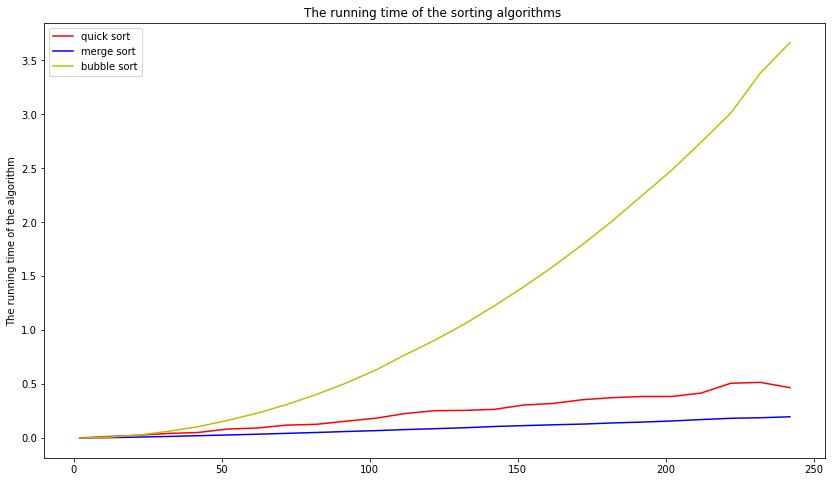

In [27]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import timeit

ns1 = range(2, 250, 10)
q_time = [quick_time(n) for n in ns1 ]
m_time = [merge_time(n) for n in ns1 ]
b_time = [bubble_time(n) for n in ns1 ]



figure(figsize=(14, 8))
plt.plot(ns1, q_time, '-r', label= 'quick sort')
plt.plot(ns1, m_time, '-b', label= 'merge sort')
plt.plot(ns1, b_time, '-y', label= 'bubble sort')


plt.xlabel('') 
plt.ylabel('The running time of the algorithm') 
plt.title('The running time of the sorting algorithms ')
plt.legend()
plt.show()

### 7.7.1. Time Complexity

Merge sort is the best algorithm we can choose, by the way, quick sort and merge sort have the same behavior as $\Theta(nlog(n))$.
The point is that the efficiency of quicksort is extremely related to how we select the pivot. If the partitions created are very unbalanced, quicksort becomes very slow and inefficient.

Basically, the main idea is the same, both algorithms partition the array, merge sort always of size $\frac{n}{2}$ while quick sort doesn't necessarily do that.

Merge sort performs fewer comparisons than Quicksort in both the average and worst cases.

### 7.7.2. Space Complexity

Merge sort requires creating subarrays in addition to the original array. and hence, the algorithm must create n items in memory. Therefore, the complexity of the space is $\Theta(n)$

Quicksort is an in-place sorting algorithm. Its memory complexity is O(1).

### 7.7.3. Conclusion

Merge sort is very efficient for any particular list, but if the cost of allocating new memory is very high, we should always prefer quicksort.

Quicksort is very efficient at sorting small datasets. If the dataset to be sorted is too large to fit in memory all at once, using quicksort would not be possible.